<a href="https://colab.research.google.com/github/annimaryks/Content-Based_music_recommendation/blob/main/music_recom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors, RadiusNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer


In [2]:
# dataset Loading
data = pd.read_csv('music_genre.csv')
data.head()


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [3]:
# Cleaning the data
data.dropna(inplace=True)
tempo_index = data[data.tempo == '?'].index
data.drop(tempo_index, inplace=True)
data = data[data['duration_ms'] != -1.0]
data.drop_duplicates(['instance_id', 'track_name'], inplace=True)
data['music_genre'] = data['music_genre'].str.strip('[]').str.replace(' ', '').str.replace("'", '')
data['music_genre'] = data['music_genre'].str.split(',')
data['music_genre'] = data['music_genre'].apply(lambda x: ','.join(map(str, x))) # Convert lists to strings
data.head()


<ipython-input-3-eada315ff046>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(['instance_id', 'track_name'], inplace=True)
<ipython-input-3-eada315ff046>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['music_genre'] = data['music_genre'].str.strip('[]').str.replace(' ', '').str.replace("'", '')
<ipython-input-3-eada315ff046>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.106,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic


In [4]:
# handeling the missing values
impute__ = SimpleImputer(strategy='mean') # Impute missing values with mean
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = impute__.fit_transform(data[numeric_cols])


#Feature Extraction:


In [5]:
# using one-hot encoding

data_en = pd.get_dummies(data, columns=['artist_name', 'track_name', 'key', 'mode', 'tempo', 'obtained_date', 'music_genre'],
                            prefix=['prefix1', 'prefix2', 'prefix3', 'prefix4', 'prefix5', 'prefix6', 'prefix7'])
print(data_en)

       instance_id  popularity  acousticness  danceability  duration_ms  \
1          46652.0        31.0       0.01270         0.622     218293.0   
2          30097.0        28.0       0.00306         0.620     215613.0   
3          62177.0        34.0       0.02540         0.774     166875.0   
4          24907.0        32.0       0.00465         0.638     222369.0   
6          43760.0        46.0       0.02890         0.572     214408.0   
...            ...         ...           ...           ...          ...   
49999      28408.0        56.0       0.13300         0.849     237667.0   
50001      43557.0        72.0       0.15700         0.709     251860.0   
50002      39767.0        51.0       0.00597         0.693     189483.0   
50003      57944.0        65.0       0.08310         0.782     262773.0   
50004      63470.0        67.0       0.10200         0.862     267267.0   

       energy  instrumentalness  liveness  loudness  speechiness  ...  \
1       0.890          0.9

In [6]:
#Extracting Features from Text:

# Replacing NaN with a empty string
data['artist_name'].fillna('', inplace=True)
data['track_name'].fillna('', inplace=True)

# Using TF-IDF on 'artist_name' and 'track_name'
tfidf_vectorizer = TfidfVectorizer()
combined_tfidf = tfidf_vectorizer.fit_transform(data['artist_name'] + ' ' + data['track_name'])

print(combined_tfidf)

  (0, 16005)	0.5573696098412595
  (0, 19103)	0.5636786873394448
  (0, 21274)	0.16676832020596727
  (0, 5027)	0.4143284575844648
  (0, 21310)	0.4148803587494122
  (1, 10269)	0.6345117858275329
  (1, 8151)	0.5278410794254677
  (1, 6063)	0.5646048073802704
  (2, 15067)	0.7408233040106527
  (2, 6551)	0.6716999570006985
  (3, 4898)	0.6012678165908186
  (3, 6177)	0.5407626324152051
  (3, 15177)	0.35626937136046566
  (3, 19678)	0.33624065121858243
  (3, 23243)	0.3256795167246628
  (4, 4542)	0.6256325724348614
  (4, 4807)	0.6158104293390201
  (4, 11169)	0.47891690242236135
  (5, 5788)	0.7487603474992334
  (5, 10205)	0.6628408119698329
  (6, 1239)	0.557189217669516
  (6, 14944)	0.4957607547882316
  (6, 11509)	0.666154223678448
  (7, 2424)	0.5959367508981905
  (7, 12300)	0.5723036105361293
  :	:
  (40555, 2282)	0.5922547677575566
  (40555, 6256)	0.5455632545746663
  (40555, 15010)	0.33949121166242924
  (40556, 6418)	0.402314554429458
  (40556, 18106)	0.479220471042576
  (40556, 23526)	0.48860892

In [42]:
# Preprocessing the data
scaler = StandardScaler()
scaled_featur = scaler.fit_transform(data[numeric_cols])


#PCA

In [43]:
# PCA (principal component analysis)
# Retain 95% of the variance
pca__ = PCA(n_components=0.95)
pca_featur = pca__.fit_transform(scaled_featur)

In [44]:
# Display the PCA Results
# display the principal components
print("PCA Components:", pca__.components_)
# display the explained variance ratio
print("Explained Variance Ratio:", pca__.explained_variance_ratio_)

PCA Components: [[-0.00550759 -0.25921427  0.42369449 -0.3135329   0.13518139 -0.43741781
   0.34239824 -0.08274594 -0.45871493 -0.17690292 -0.28204947]
 [ 0.02330308 -0.35909929 -0.26546961 -0.42681805  0.41051278  0.35552638
   0.08897341  0.40666587  0.21729591 -0.29204846 -0.13089667]
 [-0.0828113   0.19644872  0.07761133 -0.0683493   0.115099   -0.10403465
  -0.11026828  0.5716667  -0.08714021  0.67105359 -0.35059352]
 [-0.99017044  0.00701091 -0.03799445  0.00447666  0.06895514  0.01959276
   0.00997355 -0.09846122  0.02458565 -0.04763107 -0.01561358]
 [ 0.10481367  0.45991994 -0.15311018 -0.06368886  0.54097243  0.00252007
  -0.09559689 -0.49554329  0.09234637 -0.01449942 -0.4403308 ]
 [ 0.02098828 -0.08179679  0.0825854   0.42086629  0.67687251 -0.05436295
   0.23437294  0.0723903  -0.11944654  0.15718526  0.49866076]
 [-0.0241315   0.41975397  0.24740923 -0.04019751  0.12720526 -0.21328101
  -0.48407366  0.37886659 -0.08065982 -0.52866018  0.1867414 ]
 [ 0.00587796 -0.4736366 

In [13]:
# lets assume 'y__' is target variable with some data
y__ = ["Electronic", "Anime", "Jazz", "Alternative", "Country","Rap", "Blues", "Rock", "Classical", "Hip-Hop"]

# using lable encoding to convert the categorical variables to numerical
label_encoder = LabelEncoder()
#  'y__' is Transformed using fit_transform
y_encoded = label_encoder.fit_transform(y__)

In [14]:
# Training-testing and split data using PCA-transformed features
X_train, X_test, y_train, y_test = train_test_split(pca_featur, data['music_genre'], test_size=0.2, random_state=42)


#EDA

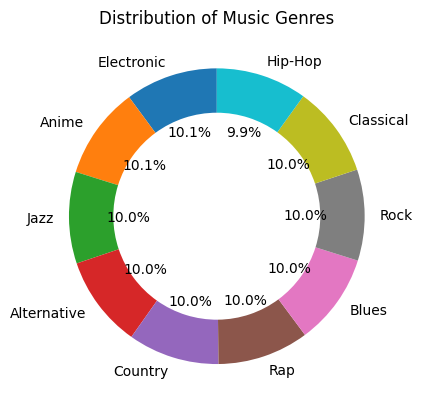

In [15]:
#Understanding the Target Variable:

# To plot the distribution of the target variable
plt.pie(data['music_genre'].value_counts(), labels=data['music_genre'].unique(), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.title('Distribution of Music Genres')
plt.show()

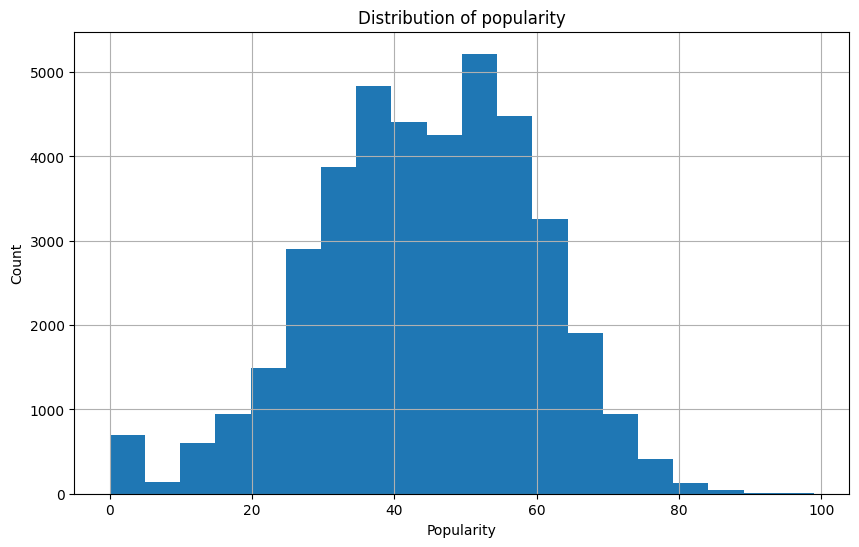

In [16]:

#Exploring Numerical Feature Distributions:

plt.figure(figsize=(10, 6))
data['popularity'].hist(bins=20)
plt.title('Distribution of popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

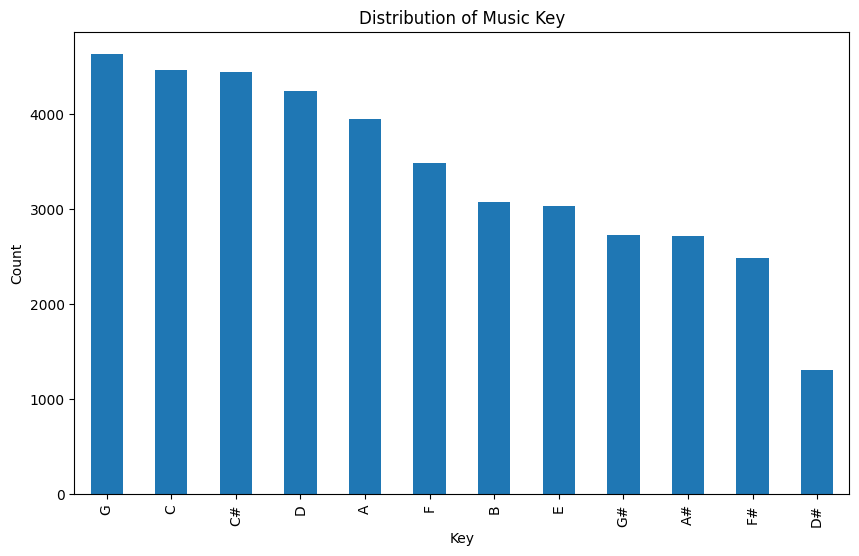

In [17]:
#Explore Categorical Features Distibution:

plt.figure(figsize=(10, 6))
data['key'].value_counts().plot(kind='bar')
plt.title('Distribution of Music Key')
plt.xlabel('Key')
plt.ylabel('Count')
plt.show()

<ipython-input-18-9f701fe6476b>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  crl_matrix = data.corr()


                  instance_id  popularity  acousticness  danceability  \
instance_id          1.000000    0.004833     -0.004616     -0.001630   
popularity           0.004833    1.000000     -0.289318      0.357883   
acousticness        -0.004616   -0.289318      1.000000     -0.347304   
danceability        -0.001630    0.357883     -0.347304      1.000000   
duration_ms         -0.003299   -0.110858      0.085135     -0.203663   
energy               0.011107    0.216188     -0.790900      0.263884   
instrumentalness    -0.004687   -0.363928      0.387188     -0.297791   
liveness             0.005022   -0.041293     -0.108336     -0.050713   
loudness             0.007973    0.317655     -0.729482      0.389374   
speechiness         -0.005793    0.223058     -0.163502      0.277976   
valence              0.006905    0.129521     -0.272629      0.435589   

                  duration_ms    energy  instrumentalness  liveness  loudness  \
instance_id         -0.003299  0.011107   

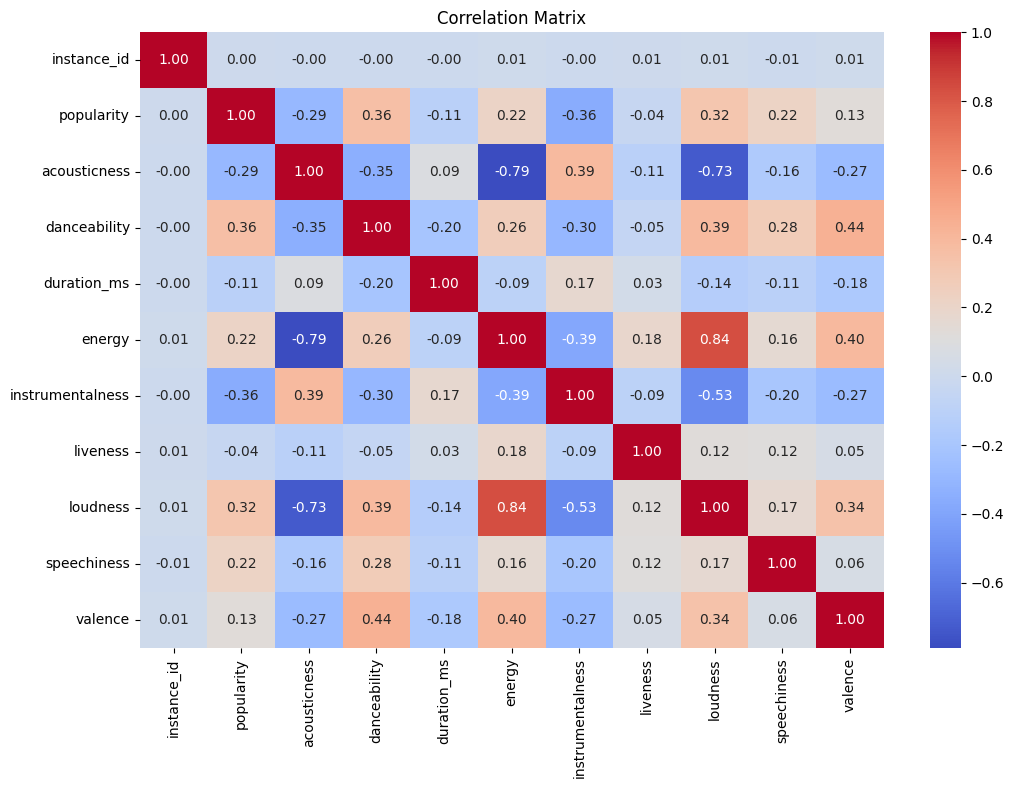

In [18]:
#Correlation Analysis between Numerical Features to find the connections/pattern:

# To display a correlation matrix
crl_matrix = data.corr()
print(crl_matrix)

# To Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(crl_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Classification models building

In [12]:
# initializing Support Vector Machines (SVM)
svm__ = SVC()
# Training classifier
svm__.fit(X_train, y_train)
# test data prediction
svm__predictions = svm__.predict(X_test)
# calculate confusion matrix
svm_conf_mtrx = confusion_matrix( y_test, svm__predictions)

# Compute accuracy
svm_ac = accuracy_score(y_test, svm__predictions)
print("SVM Accuracy:", svm_ac)

SVM Accuracy: 0.5642258382642998


In [21]:
# Display the classification report
svm_cr= classification_report(y_test, svm__predictions)
print("SVM Classification Report:")
print(svm_cr)

SVM Classification Report:
              precision    recall  f1-score   support

 Alternative       0.40      0.33      0.36       797
       Anime       0.73      0.71      0.72       827
       Blues       0.59      0.51      0.54       792
   Classical       0.85      0.85      0.85       821
     Country       0.49      0.51      0.50       804
  Electronic       0.65      0.60      0.62       843
     Hip-Hop       0.45      0.53      0.49       824
        Jazz       0.53      0.48      0.50       782
         Rap       0.45      0.37      0.40       782
        Rock       0.51      0.73      0.60       840

    accuracy                           0.56      8112
   macro avg       0.56      0.56      0.56      8112
weighted avg       0.56      0.56      0.56      8112



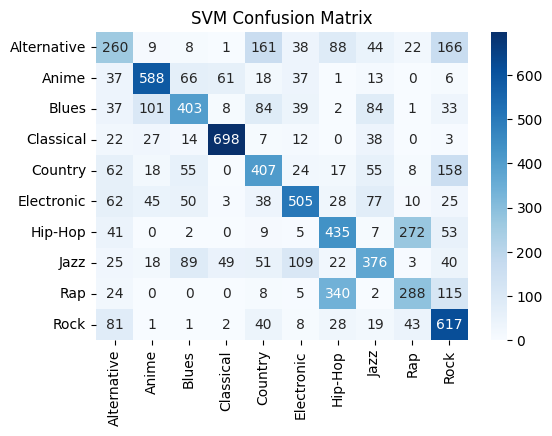

In [20]:
# Plot SVM Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(svm_conf_mtrx, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix')
plt.show()


In [19]:
#initializing  Random Forest Classifier
ran_for = RandomForestClassifier()
# Training classifier
ran_for.fit(X_train, y_train)
# test data prediction
ran_for_predictions = ran_for.predict(X_test)
# calculate confusion matrix
ran_for_conf_matrix = confusion_matrix(y_test, ran_for_predictions)

# Compute Accuracy
ran_for_ac = accuracy_score(y_test, ran_for_predictions)
print(f'Random Forest Accuracy: {ran_for_ac:.4f}')


Random Forest Accuracy: 0.5196


In [22]:
# Display the classification report
RF_cr = classification_report(y_test, ran_for_predictions)
print("Random Forest Classification Report:")
print(RF_cr)

Random Forest Classification Report:
              precision    recall  f1-score   support

 Alternative       0.36      0.32      0.34       797
       Anime       0.70      0.68      0.69       827
       Blues       0.55      0.49      0.52       792
   Classical       0.86      0.85      0.85       821
     Country       0.48      0.48      0.48       804
  Electronic       0.60      0.59      0.60       843
     Hip-Hop       0.36      0.41      0.38       824
        Jazz       0.48      0.45      0.47       782
         Rap       0.29      0.26      0.28       782
        Rock       0.49      0.62      0.55       840

    accuracy                           0.52      8112
   macro avg       0.52      0.52      0.52      8112
weighted avg       0.52      0.52      0.52      8112



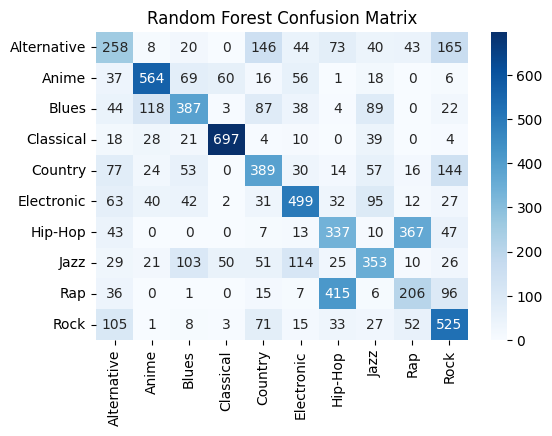

In [23]:
# Plot Random Forest Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(ran_for_conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Random Forest Confusion Matrix')
plt.show()

In [26]:
# initializing K-Nearest Neighbors Classifier (KNN)
knn__ = KNeighborsClassifier()
# Training classifier
knn__.fit(X_train, y_train)
# test data prediction
knn__predictions = knn__.predict(X_test)
# calculate confusion matrix
knn_conf_mtrx = confusion_matrix(y_test, knn__predictions)

# compute accuracy
knn__ac = accuracy_score(y_test, knn__predictions)
print(f'KNN Accuracy: {knn__ac:.2f}')


KNN Accuracy: 0.48


In [27]:
# Display the classification report
knn__cr = classification_report(y_test, knn__predictions)
print("KNN Classification Report:")
print(knn__cr)

KNN Classification Report:
              precision    recall  f1-score   support

 Alternative       0.28      0.35      0.31       797
       Anime       0.64      0.69      0.66       827
       Blues       0.47      0.43      0.45       792
   Classical       0.83      0.82      0.83       821
     Country       0.38      0.46      0.41       804
  Electronic       0.61      0.49      0.54       843
     Hip-Hop       0.40      0.44      0.42       824
        Jazz       0.44      0.35      0.39       782
         Rap       0.36      0.33      0.35       782
        Rock       0.48      0.44      0.46       840

    accuracy                           0.48      8112
   macro avg       0.49      0.48      0.48      8112
weighted avg       0.49      0.48      0.48      8112



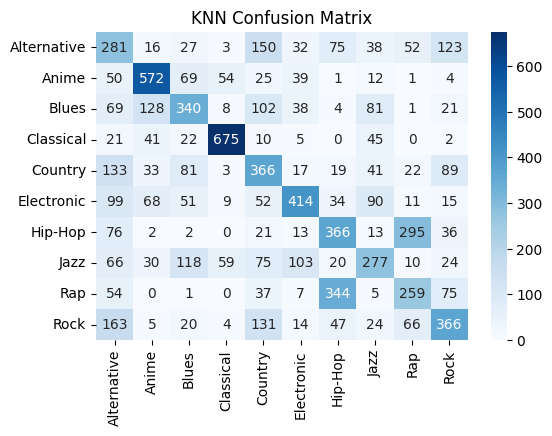

In [28]:
# Plot KNN Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(knn_conf_mtrx, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('KNN Confusion Matrix')
plt.show()


In [31]:
# initializing Neural Network Classifier
label_encoder = LabelEncoder()
y_train_en = label_encoder.fit_transform(y_train)
y_test_en = label_encoder.transform(y_test)
model_ = Sequential()
model_.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_.add(Dense(32, activation='relu'))
model_.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_.fit(X_train, y_train_en, epochs=10, batch_size=32, validation_data=(X_test, y_test_en))
nn_pred = model_.predict(X_test)
nn_class_pred = np.argmax(nn_pred, axis=1)

# change class labels to strings
targetnames_str = label_encoder.classes_.astype(str)

# Print the classification report
nn_classification_rep = classification_report(y_test_en, nn_class_pred, target_names=targetnames_str)
# calculate confusion matrix
nn_conf_mtrx = confusion_matrix(y_test_en, nn_class_pred)
print("Neural Network Classification Report:")
print(nn_classification_rep)

Epoch 1/10
1014/1014 [==============================] - 6s 5ms/step - loss: 1.3698 - accuracy: 0.4924 - val_loss: 1.2341 - val_accuracy: 0.5280
Epoch 2/10
1014/1014 [==============================] - 4s 4ms/step - loss: 1.2067 - accuracy: 0.5394 - val_loss: 1.1981 - val_accuracy: 0.5412
Epoch 3/10
1014/1014 [==============================] - 3s 3ms/step - loss: 1.1812 - accuracy: 0.5474 - val_loss: 1.1889 - val_accuracy: 0.5489
Epoch 4/10
1014/1014 [==============================] - 3s 2ms/step - loss: 1.1657 - accuracy: 0.5523 - val_loss: 1.1726 - val_accuracy: 0.5488
Epoch 5/10
1014/1014 [==============================] - 2s 2ms/step - loss: 1.1536 - accuracy: 0.5522 - val_loss: 1.1737 - val_accuracy: 0.5492
Epoch 6/10
1014/1014 [==============================] - 3s 3ms/step - loss: 1.1439 - accuracy: 0.5586 - val_loss: 1.1575 - val_accuracy: 0.5566
Epoch 7/10
1014/1014 [==============================] - 4s 4ms/step - loss: 1.1370 - accuracy: 0.5600 - val_loss: 1.1552 - val_accuracy:

In [34]:
# Compute accuracy
nn_ac = accuracy_score(y_test_en, nn_class_pred)
print(f'Neural Network Accuracy: {nn_ac:.2f}')

Neural Network Accuracy: 0.56


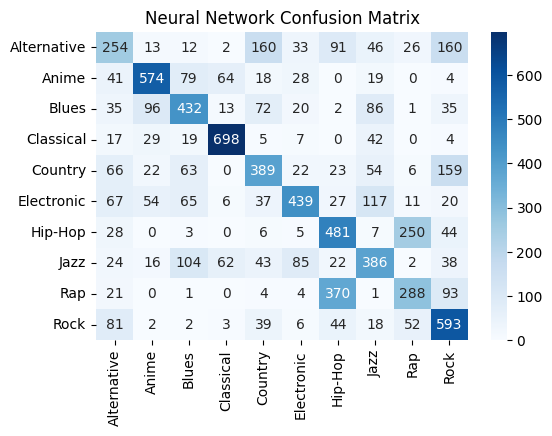

In [32]:
# Plot Neural Network Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(nn_conf_mtrx, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Neural Network Confusion Matrix')
plt.show()

In [37]:
# initializing Hybrid Classifier
svm__ = SVC()
svm__.fit(X_train, y_train)
svm__predictions = svm__.predict(X_test)
ran_for = RandomForestClassifier()
ran_for.fit(X_train, y_train)
ran_for_predictions = ran_for.predict(X_test)
knn__ = KNeighborsClassifier()
knn__.fit(X_train, y_train)
knn__predictions = knn__.predict(X_test)

# Change predictions to a str type
svm_pred_data = pd.DataFrame({'SVM': svm__predictions.astype(str)})
rf_pred_data = pd.DataFrame({'RandomForest': ran_for_predictions.astype(str)})
knn_pred_data = pd.DataFrame({'KNN': knn__predictions.astype(str)})
nn_pred_data = pd.DataFrame({'NeuralNetwork': nn_class_pred.astype(str)})

#to Concatenated predictions
hybrid_pred = pd.concat([svm_pred_data, rf_pred_data, knn_pred_data, nn_pred_data], axis=1)
hybrid_pred['Hybrid'] = hybrid_pred.mode(axis=1)[0]

# Display the classification report
hybrid_cr = classification_report(y_test, hybrid_pred['Hybrid'])
# calculate confusion matrix
hybrid_conf_mtrx = confusion_matrix(y_test, hybrid_pred['Hybrid'])
print("Hybrid Model Classification Report:")
print(hybrid_cr)




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hybrid Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
 Alternative       0.37      0.31      0.34       797
       Anime       0.72      0.71      0.72       827
       Blues       0.59      0.49      0.54       792
   Classical       0.85      0.85      0.85       821
     Country       0.49      0.48      0.48       804
  Electronic       0.65      0.57      0.61       843
     Hip-Hop       0.40      0.46      0.43  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Compute accuracy
hybrid_ac = accuracy_score(y_test, hybrid_pred['Hybrid'])
print("Hybrid Model Accuracy:", hybrid_ac)

Hybrid Model Accuracy: 0.525887573964497


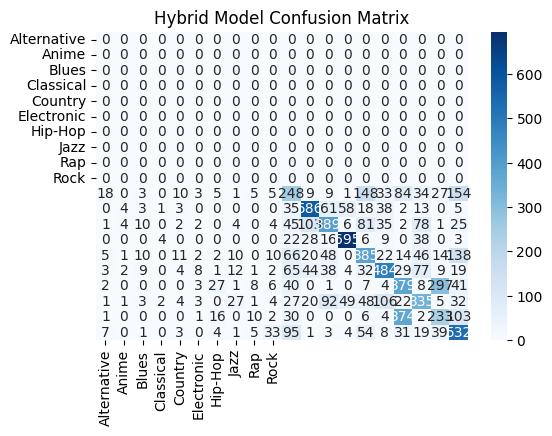

In [39]:
# Plot Hybrid Model Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(hybrid_conf_mtrx, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Hybrid Model Confusion Matrix')
plt.show()

In [45]:
#creating content-based recommendation model
def get_music(music_name):
    music_name = data[data['track_name']==music_name]
    return music_name

In [41]:
# lets assume data is dataset
def recommend_song(music_name, data):
    music = get_music(music_name)  # defining get_music function
    music_drop = music.drop('track_name', axis=1)
    music_name = pd.DataFrame(data=music_drop, index=None)

    # Selecting numeric columns for the NearestNeighbors algorithm
    num_col = data.select_dtypes(include='number')
    current_X = num_col

    neigh = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
    neigh.fit(current_X)

    # For finding suggestions, using numeric_cols.
    distances, indices = neigh.kneighbors(music_name[num_col.columns])
    recom__ = data['track_name'].iloc[indices[0]+1].values
    return recom__

recom__ = recommend_song("My Baby", data)
print(recom__)

['Goooo' 'Cyclone (feat. T-Pain) - Main' "Y No Hago Mas Na'" 'Touch'
 'What You Want']
